In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [9]:
import os
import json
import tempfile
import time
import random

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFilter
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split

# parse gt.txt
def load_annotations(gt_path):
    annotations = {}
    with open(gt_path, "r") as f:
        for line in f:
            frame, x, y, w, h = map(int, line.strip().split(","))
            if w <= 0 or h <= 0:  # skip degenerate boxes
                continue
            if frame not in annotations:
                annotations[frame] = []
            # stored as [xmin, ymin, xmax, ymax]
            annotations[frame].append([x, y, x + w, y + h])
    return annotations

# detection transforms 
class ComposeDetTransforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            result = t(image) if not callable(getattr(t, "__call__", None)) else None
            try:
                # try calling with (image, target)
                image, target = t(image, target)
            except TypeError:
                # if it only takes image, ignore target
                image = t(image)
        return image, target

class ToTensorTarget:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # float tensor [C,H,W]
        return image, target

class RandomHorizontalFlipTarget:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = F.hflip(image)
            w, _ = image.size
            boxes = target["boxes"]
            if isinstance(boxes, torch.Tensor):
                boxes = boxes.clone()
            else:
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # boxes: [xmin, ymin, xmax, ymax]
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
        return image, target

class ColorJitterOnlyImage:
    def __init__(self, brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0):
        self.args = (brightness, contrast, saturation, hue)
    def __call__(self, image, target):
        image = torchvision.transforms.ColorJitter(*self.args)(image)
        return image, target

class RandomGaussianBlur:
    def __init__(self, radius=3, p=0.3):
        self.radius = radius
        self.p = p
    def __call__(self, image, target):
        if random.random() < self.p:
            image = image.filter(ImageFilter.GaussianBlur(radius=self.radius))
        return image, target

# dataset
class PigDataset(Dataset):
    def __init__(self, img_dir, annotations, transforms=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transforms = transforms

        # only keep IDs that have a file
        self.image_ids = [
            img_id for img_id in sorted(annotations.keys())
            if os.path.exists(os.path.join(img_dir, f"{img_id:08d}.jpg"))
        ]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id:08d}.jpg")
        image = Image.open(img_path).convert("RGB")

        boxes = torch.as_tensor(self.annotations[img_id], dtype=torch.float32)
        # filter invalid boxes
        valid_mask = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        boxes = boxes[valid_mask]
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "orig_size": torch.tensor([image.size[1], image.size[0]]),  # H, W
            "size": torch.tensor([image.size[1], image.size[0]]),
        }

        if self.transforms:
            image, target = self.transforms(image, target)

        return image, target

# build model
def get_model(num_classes, use_pretrained_backbone=False):
    if use_pretrained_backbone:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# training
def collate_fn(batch):
    return tuple(zip(*batch))

def evaluate_map(model, val_loader, device):
    """
    Evaluate predictions on val_loader and compute COCO mAP@50 using pycocotools.
    """
    from pycocotools.coco import COCO
    from pycocotools.cocoeval import COCOeval

    model.eval()
    preds, gts = [], []
    ann_id = 1
    images_list = []

    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs_dev = [img.to(device) for img in imgs]
            outputs = model(imgs_dev)

            for out, tgt in zip(outputs, targets):
                img_id = int(tgt["image_id"].item())
                H, W = int(tgt["size"][0].item()), int(tgt["size"][1].item())
                images_list.append({"id": img_id, "width": W, "height": H})

                boxes = out.get("boxes", torch.empty((0, 4))).cpu().numpy()
                scores = out.get("scores", torch.empty((0,))).cpu().numpy()

                for (x1, y1, x2, y2), sc in zip(boxes, scores):
                    if sc < 0.05:
                        continue
                    preds.append({
                        "image_id": img_id,
                        "category_id": 1,
                        "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                        "score": float(sc),
                    })

                gt_boxes = tgt["boxes"].cpu().numpy()
                for b in gt_boxes:
                    w, h = float(b[2] - b[0]), float(b[3] - b[1])
                    gts.append({
                        "id": ann_id,
                        "image_id": img_id,
                        "category_id": 1,
                        "bbox": [float(b[0]), float(b[1]), w, h],
                        "area": w * h,
                        "iscrowd": 0,
                    })
                    ann_id += 1

    if len(preds) == 0 or len(gts) == 0:
        print("no detections or gt found during eval")
        return 0.0

    # save to temp JSON files 
    tmp_dir = tempfile.gettempdir()
    gt_file = os.path.join(tmp_dir, "gt.json")
    dt_file = os.path.join(tmp_dir, "dt.json")
    with open(gt_file, "w") as f:
        json.dump({
            "info": {"description": "pig detection"},
            "images": images_list,
            "annotations": gts,
            "categories": [{"id": 1, "name": "pig"}]
        }, f)
    with open(dt_file, "w") as f:
        json.dump(preds, f)

    # run eval
    coco_gt = COCO(gt_file)
    coco_dt = coco_gt.loadRes(dt_file)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats[1]  # stats[1] = mAP@50

def apply_warmup(optimizer, epoch, warmup_epochs=2, base_lr=0.002):
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
        for g in optimizer.param_groups:
            g['lr'] = lr

def train_model(train_loader, val_loader, model, device, num_epochs=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    best_map = 0.0

    for epoch in range(num_epochs):
        apply_warmup(optimizer, epoch)
        model.train()
        epoch_loss = 0.0
        start = time.time()

        for i, (imgs, targets) in enumerate(train_loader):
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()
            if i % 10 == 0:
                elapsed = time.time() - start
                print(f"epoch {epoch+1}, iter {i}/{len(train_loader)}, loss: {losses.item():.4f}, time: {elapsed:.2f}s")

        lr_scheduler.step()
        avg_loss = epoch_loss / max(1, len(train_loader))
        print(f"epoch {epoch+1} avg loss: {avg_loss:.4f}")

        # eval every 3 epochs
        if (epoch + 1) % 3 == 0:
            map50 = evaluate_map(model, val_loader, device)
            print(f"validation mAP@50: {map50:.4f}")

            if map50 > best_map + 1e-4:
                best_map = map50
                torch.save(model.state_dict(), "best_model.pth")
                print("improved, model saved")

# inference, submit
def run_inference(test_dir, model, device, out_csv="submission.csv", score_thresh=0.2):
    model.eval()
    results = []
    transform = torchvision.transforms.ToTensor()

    filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".jpg")])
    with torch.no_grad():
        for i, fname in enumerate(filenames, start=1):
            img_path = os.path.join(test_dir, fname)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).to(device)
            output = model([img_tensor])[0]
            boxes = output.get("boxes", torch.empty((0,4))).cpu().numpy()
            scores = output.get("scores", torch.empty((0,))).cpu().numpy()

            pred_parts = []
            for box, score in zip(boxes, scores):
                if score < score_thresh:
                    continue
                xmin, ymin, xmax, ymax = box
                bb_left = int(xmin)
                bb_top = int(ymin)
                bb_width = int(xmax - xmin)
                bb_height = int(ymax - ymin)
                pred_parts.append(f"{score:.4f} {bb_left} {bb_top} {bb_width} {bb_height} 0")

            pred_str = " ".join(pred_parts)
            results.append({"Image_ID": i, "PredictionString": pred_str})

    pd.DataFrame(results).to_csv(out_csv, index=False)

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_img_dir = "train/img"
    test_img_dir  = "test/img"
    gt_path       = "train/gt.txt"

    ann = load_annotations(gt_path)

    train_transforms = ComposeDetTransforms([
        ColorJitterOnlyImage(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        RandomHorizontalFlipTarget(p=0.5),
        RandomGaussianBlur(radius=2, p=0.2),
        ToTensorTarget()
    ])
    val_transforms = ComposeDetTransforms([ToTensorTarget()])

    ann_items = list(ann.items())
    train_items, val_items = train_test_split(ann_items, test_size=0.1, random_state=42)
    train_ann = dict(train_items)
    val_ann   = dict(val_items)

    train_dataset = PigDataset(train_img_dir, train_ann, transforms=train_transforms)
    val_dataset   = PigDataset(train_img_dir, val_ann, transforms=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, collate_fn=collate_fn)

    model = get_model(num_classes=2, use_pretrained_backbone=True)
    model.rpn.pre_nms_top_n_train = 2000
    model.rpn.post_nms_top_n_train = 2000
    model.rpn.pre_nms_top_n_test = 1000
    model.rpn.post_nms_top_n_test = 1000

    model.to(device)

    train_model(train_loader, val_loader, model, device, num_epochs=9)

    run_inference(test_img_dir, model, device, out_csv="submission.csv")

epoch 1, iter 0/570, loss: 3.0238, time: 0.74s
epoch 1, iter 10/570, loss: 1.5567, time: 5.72s
epoch 1, iter 20/570, loss: 1.3953, time: 10.64s
epoch 1, iter 30/570, loss: 1.2630, time: 15.60s
epoch 1, iter 40/570, loss: 1.1677, time: 20.50s
epoch 1, iter 50/570, loss: 1.0943, time: 25.44s
epoch 1, iter 60/570, loss: 1.0126, time: 30.41s
epoch 1, iter 70/570, loss: 0.9442, time: 35.36s
epoch 1, iter 80/570, loss: 0.8219, time: 40.31s
epoch 1, iter 90/570, loss: 0.8981, time: 45.27s
epoch 1, iter 100/570, loss: 0.8339, time: 50.17s
epoch 1, iter 110/570, loss: 0.8090, time: 55.08s
epoch 1, iter 120/570, loss: 0.7514, time: 59.96s
epoch 1, iter 130/570, loss: 0.8092, time: 64.85s
epoch 1, iter 140/570, loss: 0.7973, time: 69.73s
epoch 1, iter 150/570, loss: 0.7534, time: 74.66s
epoch 1, iter 160/570, loss: 0.7791, time: 79.58s
epoch 1, iter 170/570, loss: 0.6233, time: 84.43s
epoch 1, iter 180/570, loss: 0.7661, time: 89.34s
epoch 1, iter 190/570, loss: 0.6399, time: 94.22s
epoch 1, iter

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(num_classes=2, use_pretrained_backbone=True)
model.rpn.pre_nms_top_n_train = 2000
model.rpn.post_nms_top_n_train = 2000
model.rpn.pre_nms_top_n_test = 1000
model.rpn.post_nms_top_n_test = 1000
model.to(device)

if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    print("loaded previous best_model.pth")
else:
    print("no previous found")

train_model(train_loader, val_loader, model, device, num_epochs=10)

run_inference("test/img", model, device, out_csv="submission.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_19964\4047063923.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

loaded previous best_model.pth
epoch 1, iter 0/570, loss: 0.2844, time: 0.51s
epoch 1, iter 10/570, loss: 0.2010, time: 5.64s
epoch 1, iter 20/570, loss: 0.2782, time: 10.58s
epoch 1, iter 30/570, loss: 0.3070, time: 15.52s
epoch 1, iter 40/570, loss: 0.2711, time: 20.49s
epoch 1, iter 50/570, loss: 0.2561, time: 25.47s
epoch 1, iter 60/570, loss: 0.2248, time: 30.45s
epoch 1, iter 70/570, loss: 0.3472, time: 35.39s
epoch 1, iter 80/570, loss: 0.3761, time: 40.34s
epoch 1, iter 90/570, loss: 0.3250, time: 45.31s
epoch 1, iter 100/570, loss: 0.3224, time: 50.24s
epoch 1, iter 110/570, loss: 0.2831, time: 55.18s
epoch 1, iter 120/570, loss: 0.2697, time: 60.13s
epoch 1, iter 130/570, loss: 0.2208, time: 65.03s
epoch 1, iter 140/570, loss: 0.2634, time: 69.86s
epoch 1, iter 150/570, loss: 0.1879, time: 74.74s
epoch 1, iter 160/570, loss: 0.2918, time: 79.62s
epoch 1, iter 170/570, loss: 0.2065, time: 84.51s
epoch 1, iter 180/570, loss: 0.2569, time: 89.46s
epoch 1, iter 190/570, loss: 0.2

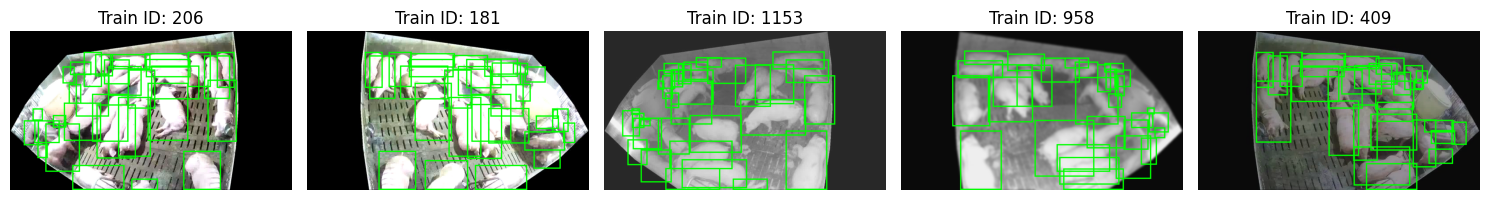

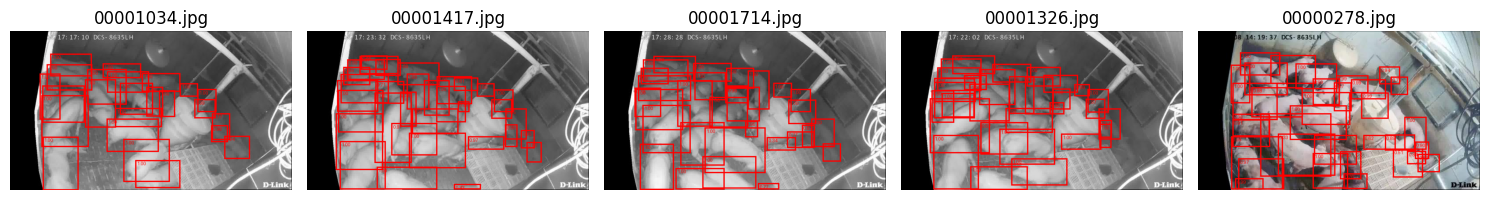

In [11]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont
import random

def draw_boxes(image, boxes, color, labels=None, scores=None):
    draw = ImageDraw.Draw(image)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        text = ""
        if labels is not None:
            text += str(labels[i])
        if scores is not None:
            text += f" {scores[i]:.2f}"
        if text:
            draw.text((x1 + 2, y1 + 2), text, fill=color)
    return image

def visualize_train_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, target = dataset[idx]
        img_pil = F.to_pil_image(img)
        boxes = target["boxes"].numpy()
        img_pil = draw_boxes(img_pil, boxes, color="lime")
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_pil)
        plt.axis("off")
        plt.title(f"Train ID: {target['image_id'].item()}")
    plt.tight_layout()
    plt.show()

def visualize_test_predictions(test_dir, model, device, num_samples=5, score_thresh=0.3):
    model.eval()
    filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".jpg")])
    chosen = random.sample(filenames, min(num_samples, len(filenames)))
    plt.figure(figsize=(15, num_samples * 3))

    for i, fname in enumerate(chosen):
        img_path = os.path.join(test_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img_tensor = torchvision.transforms.ToTensor()(img).to(device)

        with torch.no_grad():
            outputs = model([img_tensor])[0]

        boxes = outputs["boxes"].cpu().numpy()
        scores = outputs["scores"].cpu().numpy()

        keep = scores >= score_thresh
        boxes = boxes[keep]
        scores = scores[keep]

        img_pred = img.copy()
        img_pred = draw_boxes(img_pred, boxes, color="red", scores=scores)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_pred)
        plt.axis("off")
        plt.title(fname)
    plt.tight_layout()
    plt.show()

visualize_train_samples(train_dataset, num_samples=5)

visualize_test_predictions("test/img", model, device, num_samples=5, score_thresh=0.3)